In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal
import matplotlib

In [2]:
plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)

        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_3 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_4 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        # self.layer_5 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        # self.layer_6 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)

        self.layerout = nn.Linear(self.hidden_dim, x_dim-1, bias=True)
                
    def forward(self, x, t):
        z_in = torch.concat((x,t),dim=1)

        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.layer_2(h_temp)
        h = self.activation(h_temp + h)

        h_temp = self.activation(self.layer_3(h))
        h_temp = self.layer_4(h_temp)
        h = self.activation(h_temp + h)

        # h_temp = self.activation(self.layer_5(h))
        # h_temp = self.layer_6(h_temp)
        # h = self.activation(h_temp + h)
        
        z_out = self.layerout(h) 
        return z_out

In [4]:
N = 2000 # number of samples
T = 2000  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 8.0 # time horizon
# dt = tf/T # time step

n_sigma = 0.3 # noise level

# A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [5]:
y = torch.tensor([[0.0],[0.0]])
x_0 = torch.tensor([[torch.pi],[0.0]])

In [6]:
t = torch.linspace(0,tf,T).reshape(-1,1) ## time grid shape (T,1)

In [7]:
U_d = torch.zeros(T,m) # control sequence
# A_lin = torch.tensor([[0.0, 1.0],[-1.0, -0.01]])
# Q = torch.tensor([[10.0, 0.0],[0.0, 1.0]])
# R = torch.tensor([[1.0]])
# P = sp.linalg.solve_continuous_are(A_lin.numpy(), B.numpy(), Q.numpy(), R.numpy())
# K = (torch.linalg.inv(R) @ B.T @ P).to(torch.float32)*0

In [8]:
dt = t[1] - t[0]
# X_forward = torch.zeros((T, n))
# X_forward[0,:] = x_0.squeeze(-1)
# for i in range(1, T):
#     # print(i)
#     U_d[i-1,:] = -K @ (X_forward[i-1,:]-y.squeeze(-1)).unsqueeze(-1)
#     df1 = X_forward[i-1,1]
#     df2 = torch.sin(X_forward[i-1,0]) - 0.01*X_forward[i-1,1] 
#     df = torch.stack([df1,df2],dim=0)
#     X_forward[i,:] = (df.T + B @ U_d[i-1,:]) * dt + X_forward[i-1,:]

# plt.figure()
# plt.plot(X_forward[:,0], X_forward[:,1])
# plt.show()

In [9]:
dt

tensor([0.0040])

In [10]:
### Generate backward data
X_backward = torch.zeros((T, N, n))
X_backward[-1,:,:] = y.repeat(N,1).reshape(N,n)
for i in range(T-1, 0, -1):
    # print(i)
    df1 = X_backward[i,:,1]
    df2 = torch.sin(X_backward[i,:,0]) - 0.01 * X_backward[i,:,1]
    df = torch.stack((df1, df2), dim=1)
    # print(df.shape)
    dX = (df.T  + B @ U_d[i-1,:].repeat(N,1).T).T * dt + (B @ (n_sigma * torch.randn(N,1)*np.sqrt(dt)).T).T
    X_backward[i-1,:,:] = X_backward[i,:,:] - dX

In [11]:
# U_d

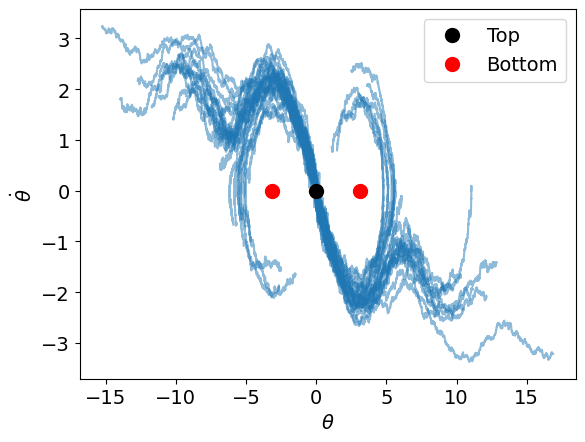

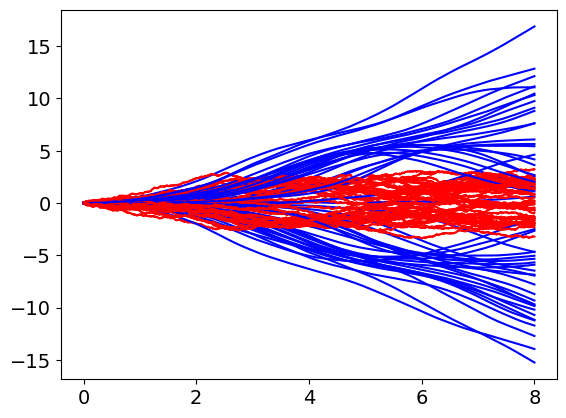

In [29]:
plt.figure()
for i in range(50):
    plt.plot(X_backward[:,i,0], X_backward[:,i,1], color='C0', alpha=0.5)
plt.plot(0,0,color='black',marker='o',markersize=10,label='Top', ls='None')
plt.plot(np.pi,0,color='red',marker='o',markersize=10,label='Bottom', ls='None')
plt.plot(-np.pi,0,color='red',marker='o',markersize=10)
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
# plt.show()
plt.savefig('pendulum_backward.pdf', bbox_inches='tight')

plt.figure()
for i in range(50):
    plt.plot(tf-t, X_backward[:,i,0], color='b')
    plt.plot(tf-t, X_backward[:,i,1], color='r')
plt.show()

# plt.figure()
# plt.plot(X_backward[:,:,0].mean(axis=1), X_backward[:,:,1].mean(axis=1))
# plt.show()

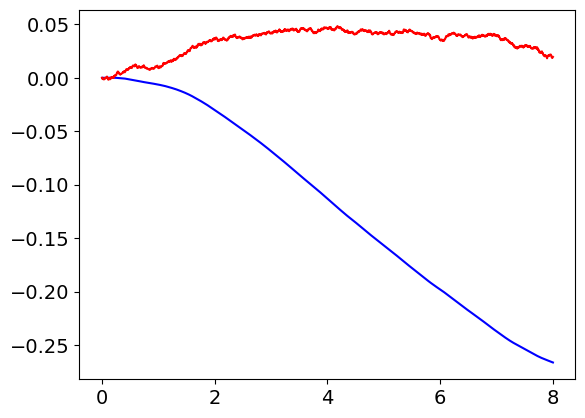

In [13]:
plt.figure()
plt.plot(tf-t,X_backward[:,:,0].mean(axis=1), color='b')
plt.plot(tf-t,X_backward[:,:,1].mean(axis=1), color='r')
plt.show()

In [14]:
def jacobian(y: torch.Tensor, x: torch.Tensor, need_higher_grad=True) -> torch.Tensor:
    (Jac,) = torch.autograd.grad(
        outputs=(y.flatten(),),
        inputs=(x,),
        grad_outputs=(torch.eye(torch.numel(y)),),
        create_graph=need_higher_grad,
        allow_unused=True,
        is_grads_batched=True
    )
    if Jac is None:
        Jac = torch.zeros(size=(y.shape + x.shape))
    else:
        Jac.reshape(shape=(y.shape + x.shape))
    return Jac

In [15]:
def batched_jacobian(batched_y:torch.Tensor,batched_x:torch.Tensor,need_higher_grad = True) -> torch.Tensor:
    sumed_y = batched_y.sum(dim = 0) # y_shape
    J = jacobian(sumed_y,batched_x,need_higher_grad) # y_shape x N x x_shape
    
    dims = list(range(J.dim()))
    dims[0],dims[sumed_y.dim()] = dims[sumed_y.dim()],dims[0]
    J = J.permute(dims = dims) # N x y_shape x x_shape
    return J

In [16]:
### learning k(x,t)###
t_N = t.repeat(1,N).reshape(T,N,1)
ITERS = 30000
BATCH_SIZE = 32
LR = 1e-3

k = score_nn(n,32)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=500, gamma=0.95)

losses = []
for i in range(ITERS):
    # print(i)
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_backward[:,idx,:]
    X_train = X_train.view(-1, n)
    t_train = t_N[:,idx,:]  
    t_train = t_train.view(-1, 1)
    X_train.requires_grad = True
    k_value = k.forward(X_train, t_train) 
    # print(k_value.shape)
    gk = k_value @ B.T # shape (T*B, n)
    # gk = gk.unsqueeze(1) # shape (T*B, 1, n)
    batch_norm = torch.einsum('tij,tjk->tik', gk.unsqueeze(1), gk.unsqueeze(2)).squeeze(-1) # shape (T*B,1)
    # loss = score_norm

    batch_jac = batched_jacobian(gk, X_train)
    temp = torch.einsum('ij,tjk->tik', B@B.T, batch_jac)
    batch_trace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
    loss = (0.5*batch_norm + batch_trace).sum()/BATCH_SIZE/T
    

    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%1000==0:
        k_value = k.forward(X_train, t_train) 
        gk = k_value @ B.T
        score_norm = torch.sum(gk**2)/BATCH_SIZE/T
        # loss = score_norm
        
        BatchJac = batched_jacobian(gk, X_train)
        temp = torch.einsum('ij,tjk->tik', B@B.T, BatchJac)
        BatchTrace = temp.diagonal(offset=0, dim1=1, dim2=2).sum(dim=1, keepdim=True) # shape (T*B, 1)
        loss = 0.5*score_norm + BatchTrace.sum()/BATCH_SIZE/T
        losses.append(loss.item())

        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 1000/30000, loss = -8.227612495422
Iteration: 2000/30000, loss = -9.329410552979
Iteration: 3000/30000, loss = -11.161344528198
Iteration: 4000/30000, loss = -11.892074584961
Iteration: 5000/30000, loss = -11.507341384888
Iteration: 6000/30000, loss = -13.966024398804
Iteration: 7000/30000, loss = -14.238610267639
Iteration: 8000/30000, loss = -13.292505264282
Iteration: 9000/30000, loss = -11.486773490906
Iteration: 10000/30000, loss = -12.450102806091
Iteration: 11000/30000, loss = -12.653804779053
Iteration: 12000/30000, loss = -14.079442024231
Iteration: 13000/30000, loss = -12.275351524353
Iteration: 14000/30000, loss = -14.497165679932
Iteration: 15000/30000, loss = -13.110859870911
Iteration: 16000/30000, loss = -13.154009819031
Iteration: 17000/30000, loss = -14.017791748047
Iteration: 18000/30000, loss = -14.142356872559
Iteration: 19000/30000, loss = -14.346714973450
Iteration: 20000/30000, loss = -15.458346366882
Iteration: 21000/30000, loss = -14.788105010986
Ite

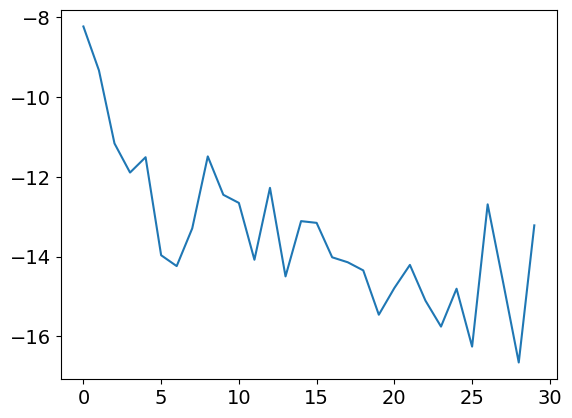

In [17]:
plt.figure()
plt.plot(losses)
plt.show()


In [18]:
# exp1tAtrans = generate_expAt(A.T, 1-t)
# phi1t = generate_phit(1-t, n)
# exp1tA = generate_expAt(A, 1-t)
# expt1A = generate_expAt(A, t-1)


In [19]:
W_forward = torch.zeros((T, N, 1))
for i in range(T):
    W_forward[i,:,:] = torch.randn(N,1)*np.sqrt(dt)

In [37]:
k_record = torch.zeros((T, N, 1))
# u_s_record = torch.zeros((T, N, 1))
u1_record = torch.zeros((T, N, 1))
# u2_record = torch.zeros((T, N, 1))
# u3_record = torch.zeros((T, N, 1))
X_pred = torch.zeros((T, N, n))
X_pred[0,:int(N/2),:] = x_0.repeat(1,int(N/2)).T
X_pred[0,int(N/2):,:] = -x_0.repeat(1,int(N/2)).T
X_pred2 = torch.zeros((T, N, n))
X_pred2[0,:int(N/2),:] = x_0.repeat(1,int(N/2)).T
X_pred2[0,int(N/2):,:] = -x_0.repeat(1,int(N/2)).T
# X_pred2 = torch.zeros((T, N, n))
# X_pred2[0,:,:] = torch.zeros((N,n))
# X_pred3 = torch.zeros((T, N, n))
# X_pred3[0,:,:] = torch.zeros((N,n))

for i in range(1, T):

    ## NN method
    k_value = k.forward(X_pred[i-1,:,:], t[i-1].repeat(N,1))
    k_record[i-1,:,:] = k_value*n_sigma**2
    u = U_d[i-1,:].repeat(N,1) + k_value*n_sigma**2
    u1_record[i-1,:,:] = u
    df1 = X_pred[i-1,:,1]
    df2 = torch.sin(X_pred[i-1,:,0]) - 0.01 * X_pred[i-1,:,1]
    df = torch.stack((df1, df2), dim=1)
    dX = (df.T  + B @ u.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred[i,:,:] = X_pred[i-1,:,:] + dX
    u2 = 0*u
    df12 = X_pred2[i-1,:,1]
    df22 = torch.sin(X_pred2[i-1,:,0]) - 0.01 * X_pred2[i-1,:,1]
    df2 = torch.stack((df12, df22), dim=1)
    dX2 = (df2.T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2

    ## u deterministic + u stochastic method
    # u_s_record[i,:,:] = -(X_pred2[i-1,:,:] - X_forward[i-1,:])@ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    # u2 = U_d[i-1,:].repeat(N,1) + u_s_record[i,:,:]
    # u2_record[i-1,:,:] = u2
    # dX2 = (A @ X_pred2[i-1,:,:].T  + B @ u2.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    # X_pred2[i,:,:] = X_pred2[i-1,:,:] + dX2
    
    # ## u feedback method
    # u3 = -(X_pred3[i-1,:,:] - (expt1A[i-1,:,:] @ y).repeat(1,N).T) @ (B.T @ exp1tAtrans[i-1,:,:] @ torch.linalg.pinv(phi1t[i-1,:,:]) @ exp1tA[i-1,:,:]).T
    # u3_record[i-1,:,:] = u3
    # dX3 = (A @ X_pred3[i-1,:,:].T  + B @ u3.T).T * dt + (B @ (n_sigma * W_forward[i-1,:,:]).T).T
    # X_pred3[i,:,:] = X_pred3[i-1,:,:] + dX3
    

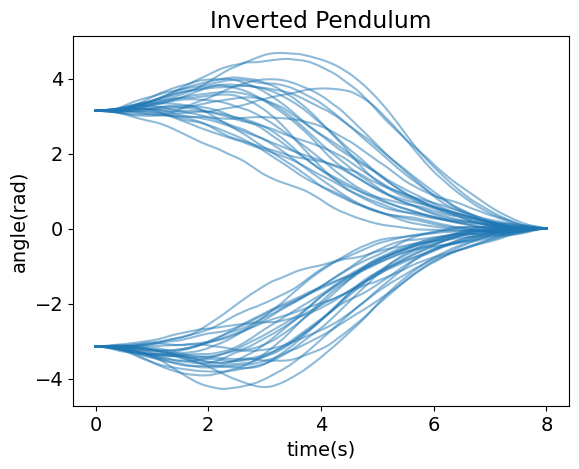

In [38]:
plt.figure()
for i in range(50):
    plt.plot(t, X_pred[:,i-25,0].detach().numpy(), color='C0', alpha=0.5)
plt.title('Inverted Pendulum')
plt.xlabel('time(s)')
plt.ylabel('angle(rad)')
plt.show()

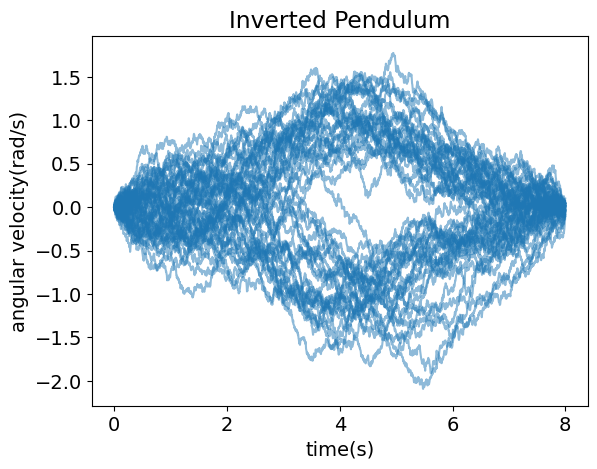

In [39]:
plt.figure()
for i in range(50):
    plt.plot(t, X_pred[:,i-25,1].detach().numpy(), color='C0', alpha=0.5)
plt.title('Inverted Pendulum')
plt.xlabel('time(s)')
plt.ylabel('angular velocity(rad/s)')
plt.show()


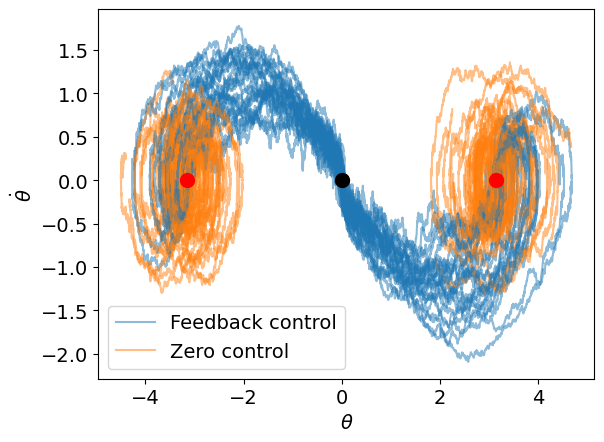

In [43]:
plt.figure()
for i in range(50):
    if i==0:
        plt.plot(X_pred[:,i-25,0].detach().numpy(), X_pred[:,i-25,1].detach().numpy(), color='C0', alpha=0.5, label='Feedback control')
        plt.plot(X_pred2[:,i-25,0].detach().numpy(), X_pred2[:,i-25,1].detach().numpy(), color='C1', alpha=0.5, label='Zero control')
    else:
        plt.plot(X_pred[:,i-25,0].detach().numpy(), X_pred[:,i-25,1].detach().numpy(), color='C0', alpha=0.5)
        plt.plot(X_pred2[:,i-25,0].detach().numpy(), X_pred2[:,i-25,1].detach().numpy(), color='C1', alpha=0.5)
plt.legend()
# plt.title('Inverted Pendulum')
plt.plot(0,0,color='black',marker='o',markersize=10,label='Top')
plt.plot(np.pi,0,color='red',marker='o',markersize=10,label='Bottom')
plt.plot(-np.pi,0,color='red',marker='o',markersize=10,label='Bottom')
# plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
# plt.show()
plt.savefig('inverted_pendulum_nonoise.pdf',bbox_inches='tight')

# plt.figure()
# plt.plot(X_pred[:,:,0].mean(axis=1).detach().numpy(), X_pred[:,:,1].mean(axis=1).detach().numpy())
# plt.show()

In [42]:
print(X_pred[-1,:,:].detach().numpy().std(axis=0))
print(X_pred[-1,:,:].detach().numpy().mean(axis=0))

[0.00316315 0.05392407]
[-0.00053817 -0.00618701]


In [25]:
# plt.figure()
# for i in range(3):
#     plt.plot(X_pred2[:,i,0].detach().numpy(), X_pred2[:,i,1].detach().numpy())
# plt.show()

# plt.figure()
# plt.plot(X_pred2[:,:,0].mean(axis=1).detach().numpy(), X_pred2[:,:,1].mean(axis=1).detach().numpy())
# plt.show()

In [26]:
# plt.figure()
# for i in range(3):
#     plt.plot(X_pred3[:,i,0].detach().numpy(), X_pred3[:,i,1].detach().numpy())
# plt.show()

# plt.figure()
# plt.plot(X_pred3[:,:,0].mean(axis=1).detach().numpy(), X_pred3[:,:,1].mean(axis=1).detach().numpy())
# plt.show()

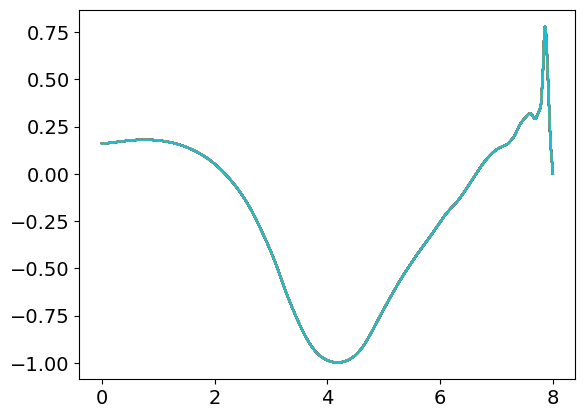

In [35]:
plt.figure()
for i in range(50):
    plt.plot(t, k_record[:,i,0].detach().numpy())
    # plt.plot(u_s_record[:,i,0].detach().numpy(), color='b')
plt.show()

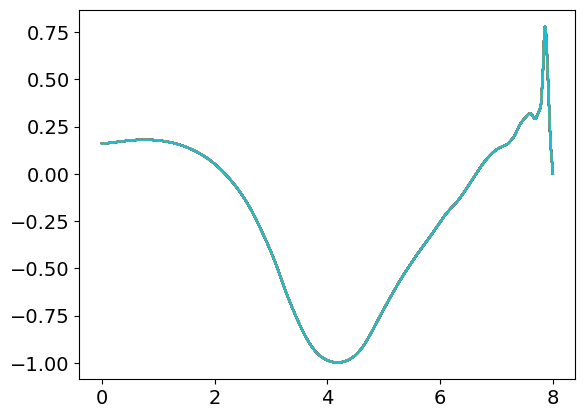

In [36]:
plt.figure()
for i in range(50):
    plt.plot(t, u1_record[:,i,0].detach().numpy())
    # plt.plot(u2_record[:99,i,0].detach().numpy(), color='b')
    # plt.plot(u3_record[:99,i,0].detach().numpy(), color='g')
plt.show()

In [47]:
print(k)

score_nn(
  (activation): ELU(alpha=1.0)
  (layer_input): Linear(in_features=3, out_features=32, bias=True)
  (layer_1): Linear(in_features=32, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=32, bias=True)
  (layer_4): Linear(in_features=32, out_features=32, bias=True)
  (layerout): Linear(in_features=32, out_features=1, bias=True)
)
